In [32]:
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_KEY = os.environ['OPENAI_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY'] 

# load all the templates in jinja2
from jinja2 import Environment, FileSystemLoader

env = Environment(loader=FileSystemLoader('../templates'))
DEFAULT_REPORT_STRUCTURE = env.get_template('DEFAULT_REPORT_STRUCTURE.jinja2').render()
REPORT_SECTION_QUERY_GENERATOR_PROMPT = env.get_template('REPORT_SECTION_QUERY_GENERATOR_PROMPT.jinja2').render()
REPORT_PLAN_QUERY_GENERATOR_PROMPT = env.get_template('REPORT_PLAN_QUERY_GENERATOR_PROMPT.jinja2').render()
REPORT_PLAN_SECTION_GENERATOR_PROMPT = env.get_template('REPORT_PLAN_SECTION_GENERATOR_PROMPT.jinja2').render()
SECTION_WRITER_PROMPT = env.get_template('SECTION_WRITER_PROMPT.jinja2').render()
FINAL_SECTION_WRITER_PROMPT = env.get_template('FINAL_SECTION_WRITER_PROMPT.jinja2').render()


In [8]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from typing import  Annotated, List, Optional, Literal

"""We use LangGraph to build our agentic system as a graph with nodes where each node consists
 of a specific execution step in the overall workflow. Each specific set of operations (nodes) 
 will have their own schema as defined below"""
# Competitive landscape analysis
# Market trajectory and opportunity identification
# Technology adoption patterns and trends
# Product/service positioning insights
# Industry development tracking

# defines structure for each section in the report
class Section(BaseModel):
    name: str = Field(
        description="Name for a particular section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description="Whether to perform web search for this section of the report."
    )
    content: str = Field(
        description="The content for this section."
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description="All the Sections of the overall report.",
    )

# defines structure for queries generated for deep research
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of web search queries.",
    )

# consists of input topic and output report generated
class ReportStateInput(TypedDict):
    topic: str # Report topic

class ReportStateOutput(TypedDict):
    final_report: str # Final report

# overall agent state which will be passed and updated in nodes in the graph
class ReportState(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of report sections
    completed_sections: Annotated[list, operator.add] # Send() API
    report_sections_from_research: str # completed sections to write final sections
    final_report: str # Final report

# defines the key structure for sections written using the agent 
class SectionState(TypedDict):
    section: Section # Report section
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # completed sections to write final sections
    completed_sections: list[Section] # Final key in outer state for Send() API

class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key in outer state for Send() API

Utility Functions

We define a few utility functions which will help us run parallel web search queries and format results obtained from the web.

In [9]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
import asyncio
from typing import Dict, Any, Union

# just to handle objects created from LLM reponses
@dataclass
class SearchQuery:
    search_query: str
    def to_dict(self) -> Dict[str, Any]:
        return asdict(self)

tavily_search = TavilySearchAPIWrapper()

async def run_search_queries(
    search_queries: List[Union[str, SearchQuery]],
    num_results: int = 5,
    include_raw_content: bool = False
) -> List[Dict]:
    search_tasks = []
    for query in search_queries:
        # Handle both string and SearchQuery objects
        # Just in case LLM fails to generate queries as:
        # class SearchQuery(BaseModel):
        #     search_query: str
        query_str = query.search_query if isinstance(query, SearchQuery) else str(query) # text query
        try:
            # get results from tavily async (in parallel) for each search query
            search_tasks.append(
                tavily_search.raw_results_async(
                    query=query_str,
                    max_results=num_results,
                    search_depth='advanced',
                    include_answer=False,
                    include_raw_content=include_raw_content
                )
            )
        except Exception as e:
            print(f"Error creating search task for query '{query_str}': {e}")
            continue
    # Execute all searches concurrently and await results
    try:
        if not search_tasks:
            return []
        search_docs = await asyncio.gather(*search_tasks, return_exceptions=True)
        # Filter out any exceptions from the results
        valid_results = [
            doc for doc in search_docs
            if not isinstance(doc, Exception)
        ]
        return valid_results
    except Exception as e:
        print(f"Error during search queries: {e}")
        return []

2. format_search_query_results(…)

This will extract the context from Tavily search results, make sure content is not duplicated from the same URLs and format it to show the Source, URL, and relevant content (and optionally raw content which can be truncated based on the number of tokens)

In [10]:
import tiktoken
from typing import List, Dict, Union, Any

def format_search_query_results(
    search_response: Union[Dict[str, Any], List[Any]],
    max_tokens: int = 2000,
    include_raw_content: bool = False
) -> str:
    encoding = tiktoken.encoding_for_model("gpt-4")
    sources_list = []

    # Handle different response formats if search results is a dict
    if isinstance(search_response, dict):
        if 'results' in search_response:
            sources_list.extend(search_response['results'])
        else:
            sources_list.append(search_response)
    # if search results is a list
    elif isinstance(search_response, list):
        for response in search_response:
            if isinstance(response, dict):
                if 'results' in response:
                    sources_list.extend(response['results'])
                else:
                    sources_list.append(response)
            elif isinstance(response, list):
                sources_list.extend(response)

    if not sources_list:
        return "No search results found."

    # Deduplicate by URL and keep unique sources (website urls)
    unique_sources = {}
    for source in sources_list:
        if isinstance(source, dict) and 'url' in source:
            if source['url'] not in unique_sources:
                unique_sources[source['url']] = source

    # Format output
    formatted_text = "Content from web search:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source.get('title', 'Untitled')}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source.get('content', 'No content available')}\n===\n"

        if include_raw_content:
            # truncate raw webpage content to a certain number of tokens to prevent exceeding LLM max token window
            raw_content = source.get("raw_content", "")
            if raw_content:
                tokens = encoding.encode(raw_content)
                truncated_tokens = tokens[:max_tokens]
                truncated_content = encoding.decode(truncated_tokens)
                formatted_text += f"Raw Content: {truncated_content}\n\n"


    return formatted_text.strip()

In [11]:
docs = await run_search_queries(['langgraph'], include_raw_content=True)
output = format_search_query_results(docs, max_tokens=500, 
   include_raw_content=True)
print(output)

Content from web search:

Source LangGraph:
===
URL: https://langchain-ai.github.io/langgraph/
===
Most relevant content from source: LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Check out an
===
Raw Content: 🦜🕸️LangGraph¶




⚡ Building language agents as graphs ⚡
Note
Looking for the JS version? See the JS repo and the JS docs.
Overview¶
LangGraph is a library for building
stateful, multi-actor applications with LLMs, used to create agent and multi-agent
workflows. Check out an introductory tutorial here.
LangGraph is inspired by Pregel and Apache Beam. The public interface draws inspiration from NetworkX. LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain.
Why use LangGraph?¶
LangGraph powers production-grade agents, trusted by Linkedin, Uber, Klarna, GitLab, and many more. LangGraph provides fine-grained control over both the flow and state of your age

In [13]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

async def generate_report_plan(state: ReportState):
    """Generate the overall plan for building the report"""
    topic = state["topic"]
    print('--- Generating Report Plan ---')

    report_structure = DEFAULT_REPORT_STRUCTURE
    number_of_queries = 8

    structured_llm = llm.with_structured_output(Queries)

    system_instructions_query = REPORT_PLAN_QUERY_GENERATOR_PROMPT.format(
        topic=topic,
        report_organization=report_structure,
        number_of_queries=number_of_queries
    )

    try:
        # Generate queries
        results = structured_llm.invoke([
            SystemMessage(content=system_instructions_query),
            HumanMessage(content='Generate search queries that will help with planning the sections of the report.')
        ])
        # Convert SearchQuery objects to strings
        query_list = [
            query.search_query if isinstance(query, SearchQuery) else str(query)
            for query in results.queries
        ]
        # Search web and ensure we wait for results
        search_docs = await run_search_queries(
            query_list,
            num_results=5,
            include_raw_content=False
        )
        if not search_docs:
            print("Warning: No search results returned")
            search_context = "No search results available."
        else:
            search_context = format_search_query_results(
                search_docs,
                include_raw_content=False
            )
        # Generate sections
        system_instructions_sections = REPORT_PLAN_SECTION_GENERATOR_PROMPT.format(
            topic=topic,
            report_organization=report_structure,
            search_context=search_context
        )
        structured_llm = llm.with_structured_output(Sections)
        report_sections = structured_llm.invoke([
            SystemMessage(content=system_instructions_sections),
            HumanMessage(content="Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")
        ])

        print('--- Generating Report Plan Completed ---')
        return {"sections": report_sections.sections}

    except Exception as e:
        print(f"Error in generate_report_plan: {e}")
        return {"sections": []}

In [14]:
def generate_queries(state: SectionState):
    """ Generate search queries for a specific report section """

    # Get state
    section = state["section"]
    print('--- Generating Search Queries for Section: '+ section.name +' ---')
    # Get configuration
    number_of_queries = 5
    # Generate queries
    structured_llm = llm.with_structured_output(Queries)
    # Format system instructions
    system_instructions = REPORT_SECTION_QUERY_GENERATOR_PROMPT.format(section_topic=section.description,                                                                       number_of_queries=number_of_queries)
    # Generate queries
    user_instruction = "Generate search queries on the provided topic."
    search_queries = structured_llm.invoke([SystemMessage(content=system_instructions),
                                     HumanMessage(content=user_instruction)])

    print('--- Generating Search Queries for Section: '+ section.name +' Completed ---')
    return {"search_queries": search_queries.queries}

In [15]:
async def search_web(state: SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources."""

    # Get state
    search_queries = state["search_queries"]
    print('--- Searching Web for Queries ---')
    # Web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await run_search_queries(search_queries, num_results=6, include_raw_content=True)
    # Deduplicate and format sources
    search_context = format_search_query_results(search_docs, max_tokens=4000, include_raw_content=True)

    print('--- Searching Web for Queries Completed ---')
    return {"source_str": search_context}

Create the Section Builder Sub-Agent

This agent (or to be more specific, sub-agent) will be called several times in parallel, once for each section to search the web, get content and then write up that specific section. We leverage LangGraph’s Send construct for doing this.

In [16]:
def write_section(state: SectionState):
    """ Write a section of the report """

    # Get state
    section = state["section"]
    source_str = state["source_str"]
    print('--- Writing Section : '+ section.name +' ---')
    # Format system instructions
    system_instructions = SECTION_WRITER_PROMPT.format(section_title=section.name,                                                     section_topic=section.description,                                                       context=source_str)
    # Generate section
    user_instruction = "Generate a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])
    # Write content to the section object
    section.content = section_content.content

    print('--- Writing Section : '+ section.name +' Completed ---')
    # Write the updated section to completed sections
    return {"completed_sections": [section]}

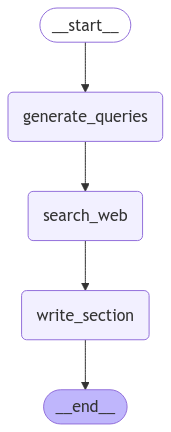

In [17]:
from langgraph.graph import StateGraph, START, END

# Add nodes and edges
section_builder = StateGraph(SectionState, output=SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)
section_builder_subagent = section_builder.compile()

# Display the graph
from IPython.display import display, Image
Image(section_builder_subagent.get_graph().draw_mermaid_png())

Create Dynamic Parallelization Node Function – Parallelize Section Writing

Send(…) is used to parallelize and call the section_builder_subagent once for each section to write up the content (in parallel)

In [18]:
from langgraph.constants import Send


def parallelize_section_writing(state: ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report in parallel and then write the section"""


    # Kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("section_builder_with_web_search", # name of the subagent node
             {"section": s})
            for s in state["sections"]
              if s.research
    ]

Create Format Sections Node Function

This is basically the section where all the sections are formatted and combined together into one big document.

In [23]:
def format_sections(sections: list[Section]) -> str:
    """ Format a list of report sections into a single text string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
{'='*60}
Section {idx}: {section.name}
{'='*60}
Description:
{section.description}
Requires Research:
{section.research}

Content:
{section.content if section.content else '[Not yet written]'}

"""
    return formatted_str

def format_completed_sections(state: ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """

    print('--- Formatting Completed Sections ---')
    # List of completed sections
    completed_sections = state["completed_sections"]
    # Format completed section to str to use as context for final sections
    completed_report_sections = format_sections(completed_sections)

    print('--- Formatting Completed Sections is Done ---')
    return {"report_sections_from_research": completed_report_sections}

In [19]:
def write_final_sections(state: SectionState):
    """ Write the final sections of the report, which do not require web search and use the completed sections as context"""

    # Get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]

    print('--- Writing Final Section: '+ section.name + ' ---')
    # Format system instructions
    system_instructions = FINAL_SECTION_WRITER_PROMPT.format(section_title=section.name,
                                                             section_topic=section.description,
                                                             context=completed_report_sections)

    # Generate section
    user_instruction = "Craft a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content=system_instructions),
                                  HumanMessage(content=user_instruction)])

    # Write content to section
    section.content = section_content.content

    print('--- Writing Final Section: '+ section.name + ' Completed ---')
    # Write the updated section to completed sections
    return {"completed_sections": [section]}

Create Dynamic Parallelization Node Function – Parallelize Final Section Writing

Send(…) is used to parallelize and call the write_final_sections once for each of the introduction and conclusion to write up the content (in parallel)

In [20]:
from langgraph.constants import Send

def parallelize_final_section_writing(state: ReportState):
    """ Write any final sections using the Send API to parallelize the process """

    # Kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections",
             {"section": s, "report_sections_from_research": state["report_sections_from_research"]})
                 for s in state["sections"]
                    if not s.research
    ]

Compile Final Report Node Function

This function combines all the sections of the report together and compiles it into the final report document



In [21]:
def compile_final_report(state: ReportState):
    """ Compile the final report """

    # Get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}

    print('--- Compiling Final Report ---')
    # Update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]

    # Compile final report
    all_sections = "\n\n".join([s.content for s in sections])
    # Escape unescaped $ symbols to display properly in Markdown
    formatted_sections = all_sections.replace("\\$", "TEMP_PLACEHOLDER")  # Temporarily mark already escaped $
    formatted_sections = formatted_sections.replace("$", "\\$")  # Escape all $
    formatted_sections = formatted_sections.replace("TEMP_PLACEHOLDER", "\\$")  # Restore originally escaped $

    # Now escaped_sections contains the properly escaped Markdown text
    print('--- Compiling Final Report Done ---')
    return {"final_report": formatted_sections}

Build our Deep Research & Report Writer Agent

We now bring all the defined components and sub-agents together and build our main planning agent.



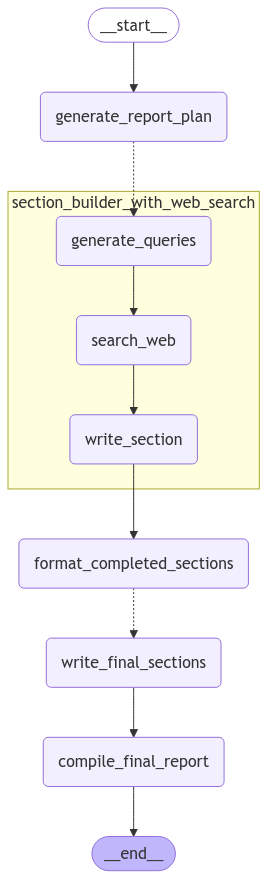

In [24]:
builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput)

builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("section_builder_with_web_search", section_builder_subagent)
builder.add_node("format_completed_sections", format_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan",
                              parallelize_section_writing,
                              ["section_builder_with_web_search"])
builder.add_edge("section_builder_with_web_search", "format_completed_sections")
builder.add_conditional_edges("format_completed_sections",
                              parallelize_final_section_writing,
                              ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

reporter_agent = builder.compile()
# view agent structure
display(Image(reporter_agent.get_graph(xray=True).draw_mermaid_png()))

We are now ready to run and test out our agentic system!

Run and Test our Deep Research & Report Writer Agent

Let’s finally put our deep research report writing agent to the test! We will create a simple function to stream the progress live and then show the final report. I would recommend to turn off all the intermediate print messages once you have a functioning agent!

In [25]:
from IPython.display import display
from rich.console import Console
from rich.markdown import Markdown as RichMarkdown

async def call_planner_agent(agent, prompt, config={"recursion_limit": 50}, verbose=False):
    events = agent.astream(
        {'topic' : prompt},
        config,
        stream_mode="values",
    )

    async for event in events:
        for k, v in event.items():
            if verbose:
                if k != "__end__":
                    display(RichMarkdown(repr(k) + ' -> ' + repr(v)))
            if k == 'final_report':
                print('='*50)
                print('Final Report:')
                md = RichMarkdown(v)
                display(md)

In [33]:
topic = "Detailed report on how is NVIDIA winning the game against its competitors"
await call_planner_agent(agent=reporter_agent,
                         prompt=topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section: NVIDIA's Market Dominance in GPU Industry ---
--- Generating Search Queries for Section: Financial Performance and Growth ---
--- Generating Search Queries for Section: Technological Innovations and Product Offerings ---
--- Generating Search Queries for Section: Challenges and Competitive Threats ---
--- Generating Search Queries for Section: Strategic Partnerships and Collaborations ---
--- Generating Search Queries for Section: Financial Performance and Growth Completed ---
--- Generating Search Queries for Section: Challenges and Competitive Threats Completed ---
--- Searching Web for Queries ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Strategic Partnerships and Collaborations Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section: Technological Innovations and Product Offerings Completed ---
--- S

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

NVIDIA stands as a formidable leader in the technology market, particularly in the GPU industry, where it commands 
an impressive 90% market share. This report delves into NVIDIA's strategic positioning, exploring its technological
innovations, financial growth, and strategic partnerships that bolster its competitive edge. Despite its dominance,
NVIDIA faces challenges from custom chip developments by major cloud service providers, which could reshape the    
competitive landscape. This report aims to provide a comprehensive analysis of NVIDIA's current market position and
the factors influencing its trajectory in the rapidly evolving tech industry.                                      


                                     NVIDIA's Market Dominance in GPU Industry                                     

NVIDIA has achieved an unprecedented 90% market share in the global GPU market as of Q3 2024, solidifying its      
dominance over competitors AMD and Intel. This dominance is largely attributed to the success of NVIDIA's RTX 50   
series, which has outperformed AMD's RX 8000 series and Intel's Arc GPUs. According to Jon Peddie Research,        
NVIDIA's market share in the discrete GPU segment reached 88% in Q1 2024, with AMD and Intel trailing significantly
behind. Despite a 7.9% decline in overall GPU shipments, NVIDIA's shipments increased by 45.6% year-over-year,     
highlighting its strong market position.                                                                           

NVIDIA's financial performance reflects its market dominance, with a reported revenue of $60.92 billion for 2024, a
126% increase from the previous year. This growth is driven by the company's strategic focus on AI and data center 
markets, where NVIDIA's GPUs are essential for AI workloads. The company's success in these sectors has been       
bolstered by its CUDA ecosystem, which has become the industry standard for AI development.                        

                                                      Sources                                                      

 • NVIDIA Crushes Rivals: Secures Unprecedented 90% of GPU Market in Q3 2024:                                      
   https://finance.yahoo.com/news/nvidia-crushes-rivals-secures-unprecedented-102235255.html                       
 • NVIDIA Dominated The AIB GPU Market In Q1 2024 With An 88% Market Share:                                        
   https://wccftech.com/nvidia-dominated-aib-gpu-market-q1-2024-88-percent-market-share-amd-12-intelt-0/           
 • NVIDIA Announces Financial Results for Fourth Quarter and Fiscal 2024:                                          
   https://investor.nvidia.com/news/press-release-details/2024/NVIDIA-Announces-Financial-Results-for-Fourth-Quarte
   r-and-Fiscal-2024/                                                                                              


                                  Technological Innovations and Product Offerings                                  

NVIDIA's advancements in AI, gaming, and data center solutions are reshaping industries with unprecedented         
performance and efficiency. At Computex 2024, NVIDIA introduced the Blackwell platform, delivering 1,000 times more
performance than its predecessor, Pascal, for AI applications. This platform supports generative AI, transforming  
data centers into AI factories with the GB200 NVL2 platform, offering 40 petaflops of AI performance and 1.3       
terabytes of memory, significantly enhancing large language model (LLM) processing.                                

In gaming, NVIDIA's GeForce RTX 5090, built o